## Import Packages

In [1]:
#### data resource https://github.com/NetManAIOps/KPI-Anomaly-Detection/tree/master/Finals_dataset
import time
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import json # for competition fscore
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from loguru import logger

import concurrent.futures # 平行運算
from tqdm import tqdm # 呈現運算進度條
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from statsmodels.tsa.api import SARIMAX, ExponentialSmoothing, SimpleExpSmoothing, Holt


#### import Keras libraries
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

## Parameter Setting

In [56]:
np.random.seed(5)
pd.set_option('display.max_rows', 270)
pd.set_option('display.max_columns', 125)

delay = 7
W_lst = [  2,   5,  10,  25,  50, 100, 200, 300, 400, 500] #288, 1440
num_of_feature_with_value = 9-4
num_of_feature_with_window = 12
sampling_rate = 25 # copy times for abnormal data
train_schema = {'timestamp':'int', 'value':'float', 'KPI ID':'str'}
test_schema = {'timestamp':'int', 'value':'float', 'KPI ID':'str'}

#### data need to be unzip first
train_path = './data/final_dataset/phase2_train.csv'
test_path = './data/final_dataset/phase2_ground_truth.hdf'

group_key = ['KPI ID']
drop_cols = ['KPI ID','status','timestamp','label','vital_label','value']

if_combine = True # True: combine train and test for feature engineering
if_sample = True # True: simplest way to copy data to balance classes, False:while use SMOTE

train_ratio = 0.8 # the ratio of train and validation

## Function
#### data preprocessing
* CustomizedLog : for log record
* FeatureEngineer : generate feature for train and test with num_of_feature_with_value and num_of_feature_with_window
* Normalization : use StandardScaler() to fit training then fit_transform testing
* FeatureEngineerAndNormalization : different ways to combine the two function above corresponds to scenarios  
* CopySampling : oversampling training set with sampling_rate(the simplest way)
* ParallelProcessing: frame of paralleling
  
#### after modeling
* get_range_proba, reconstruct_label, label_evaluation : evaluation from competition from [resources](https://github.com/chengqianghuang/exp-anomaly-detector-AIOps/blob/master/code/evaluation.py)
* FscoreFromGridSearch : find the best threshold and plot
* show_train_history : show the history of training with validation information 


In [36]:
def CustomizedLog(file_log='./log/file_{time}.log'):  # add: log folder
    logger.add(file_log,
               format="{time:YYYY-MM-DD HH:mm:ss|\
                       [{level}]|{file}|\
                       {function}()-[{line}]|\
                       {message}}",
                retention="10 days",
                encoding="utf-8",
                level="INFO")
    return logger

In [37]:
def FeatureEngineer(group):
    logger.info(f"{group['KPI ID'].unique()} is processing.")
    group = group.sort_values(by='timestamp')
    fill_ts = group.copy()
    scaler = MinMaxScaler()
    ### 特徵工程
    delay_mask = (fill_ts.label==1) & (fill_ts.label.rolling(window=delay).sum().shift(1) < delay)
    fill_ts['value'] = scaler.fit_transform(fill_ts[['value']])
    fill_ts['vital_label'] = delay_mask*1
    fill_ts['value_log'] = fill_ts.value.map(lambda x:np.log(x+1e-2))
    fill_ts['value_diff'] = fill_ts.value.diff()
    fill_ts['value_bias'] = fill_ts.value_diff/(fill_ts.value.shift(1)+1e-10)
    fill_ts['value_diff2'] = fill_ts.value_diff-fill_ts.value_diff.shift(1)
    fill_ts['value_diff3'] = fill_ts.value-fill_ts.value.expanding().mean() # accumulated mean

    for n in W_lst:
        fill_ts[f'value_rolling{n}mean'] = fill_ts.value.rolling(window=n).mean()
        fill_ts[f'value_rolling{n}mean_diff'] = fill_ts[f'value_rolling{n}mean']-fill_ts[f'value_rolling{n}mean'].shift(1)
        fill_ts[f'value_rolling{n}mean_bias'] = fill_ts[f'value_rolling{n}mean_diff']/(fill_ts[f'value_rolling{n}mean'].shift(1)+1e-10)
        fill_ts[f'value_rolling{n}mean_diff{n}'] = fill_ts[f'value_rolling{n}mean']-fill_ts[f'value_rolling{n}mean'].shift(n)
        fill_ts[f'value_rolling{n}mean_bias{n}'] = fill_ts[f'value_rolling{n}mean_diff{n}']/(fill_ts[f'value_rolling{n}mean'].shift(n)+1e-10)
        fill_ts[f'value_diff_rolling{n}mean'] = fill_ts.value-fill_ts[f'value_rolling{n}mean'].shift(1)
        fill_ts[f'value_diff{n}_rolling{n}mean'] = fill_ts.value-fill_ts[f'value_rolling{n}mean'].shift(n)
        
        fill_ts[f'value_rolling{n}var'] = fill_ts.value.rolling(window=n).var()
        fill_ts[f'value_rolling{n}var_diff'] = fill_ts[f'value_rolling{n}var']-fill_ts[f'value_rolling{n}var'].shift(1)
        fill_ts[f'value_rolling{n}var_bias'] = fill_ts[f'value_rolling{n}var_diff']/(fill_ts[f'value_rolling{n}var'].shift(1)+1e-10)
        fill_ts[f'value_rolling{n}var_diff{n}'] = fill_ts[f'value_rolling{n}var']-fill_ts[f'value_rolling{n}var'].shift(n)
        fill_ts[f'value_rolling{n}var_bias{n}'] = fill_ts[f'value_rolling{n}var_diff{n}']/(fill_ts[f'value_rolling{n}var'].shift(n)+1e-10)
    return fill_ts


In [38]:
def Normalization(group):
    logger.info(f"{group['KPI ID'].unique()} is processing.")
    cols = group.drop(columns=drop_cols).columns.tolist()
    notna_loc = np.max(W_lst)
    scaler = StandardScaler()
    if if_combine:
        train_sub = group[group.status=='train'].iloc[notna_loc*2:].copy()
        test_sub = group[group.status=='test'].copy()
        train_sub[cols] = scaler.fit_transform(train_sub[cols])
        test_sub[cols] = scaler.transform(test_sub[cols])
        group = pd.concat([train_sub, test_sub])
        return group
    else:
        group = group.iloc[notna_loc*2:].copy()
        group[cols] = scaler.fit_transform(group[cols])
        return group


In [39]:
def FeatureEngineerAndNormalization(if_combine):
    #### feature engineering & normalization
    if if_combine:
        ParallelProcessing(all_df, ['KPI ID'], FeatureEngineer, ['data_lst'])
        result = pd.concat(data_lst, axis=0)
        logger.info('feature engineering: combined data finishes.')
        ParallelProcessing(result, ['KPI ID'], Normalization, ['normalized_all_lst'])
        globals()['normalized_all'] = pd.concat(normalized_all_lst, axis=0)
        logger.info('normalizing: combined data finishes.')
    else:
        ParallelProcessing(train, ['KPI ID'], FeatureEngineer, ['train_lst'])
        train_result = pd.concat(train_lst, axis=0)
        logger.info('feature engineering: training data finishes.')
        ParallelProcessing(train_result, ['KPI ID'], Normalization, ['normalized_train_lst'])
        globals()['normalized_train'] = pd.concat(normalized_train_lst, axis=0)
        logger.info('normalizing: training data finishes.')
        
        ParallelProcessing(test, ['KPI ID'], FeatureEngineer, ['test_lst'])
        test_result = pd.concat(test_lst, axis=0)
        logger.info('feature engineering: testing data finishes.')
        ParallelProcessing(test_result, ['KPI ID'], Normalization, ['normalized_test_lst'])
        globals()['normalized_test'] = pd.concat(normalized_test_lst, axis=0)
        logger.info('normalizing: testing data finishes.')

In [40]:
def CopySampling(group):
    abnormal = group[group.label==1]
    head_abnormal = group[group.vital_label==1]
    added = pd.concat([abnormal, head_abnormal]*sampling_rate, ignore_index=True)
    sampled = pd.concat([group,added], ignore_index=True)
    return sampled

In [41]:
def ParallelProcessing(df, groupby_key_lst, func_name, var_lst):
    for var in var_lst: globals()[var] = []
    total_len = len(df.groupby(groupby_key_lst))
    if len(var_lst)>1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
            futures = [executor.submit(func_name, group) for _, group in df.groupby(groupby_key_lst)]
            with tqdm(total=total_len,position=0,leave=True) as MulProcessBar:
                for future in concurrent.futures.as_completed(futures):
                    cnt = 0
                    for var in var_lst:
                        eval(var).append(fut.result()[cnt])
                        cnt += 1
                    MulProcessBar.update(1)
                    MulProcessBar.refresh()
    else:
        with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
            futures = [executor.submit(func_name, group) for _, group in df.groupby(groupby_key_lst)]
            with tqdm(total=total_len,position=0,leave=True) as MulProcessBar:
                for fut in tqdm(concurrent.futures.as_completed(futures)):
                    eval(var_lst[0]).append(fut.result())  
                    MulProcessBar.update(1)
                    MulProcessBar.refresh()

In [42]:
# consider delay threshold and missing segments
def get_range_proba(predict, label, delay=7):
    splits = np.where(label[1:] != label[:-1])[0] + 1
    is_anomaly = label[0] == 1
    new_predict = np.array(predict)
    pos = 0

    for sp in splits:
        if is_anomaly:
            if 1 in predict[pos:min(pos + delay + 1, sp)]:
                new_predict[pos: sp] = 1
            else:
                new_predict[pos: sp] = 0
        is_anomaly = not is_anomaly
        pos = sp
    sp = len(label)

    if is_anomaly:  # anomaly in the end
        if 1 in predict[pos: min(pos + delay + 1, sp)]:
            new_predict[pos: sp] = 1
        else:
            new_predict[pos: sp] = 0

    return new_predict


# set missing = 0
def reconstruct_label(timestamp, label):
    timestamp = np.asarray(timestamp, np.int64)
    index = np.argsort(timestamp)

    timestamp_sorted = np.asarray(timestamp[index])
    interval = np.min(np.diff(timestamp_sorted))

    label = np.asarray(label, np.int64)
    label = np.asarray(label[index])

    idx = (timestamp_sorted - timestamp_sorted[0]) // interval

    new_label = np.zeros(shape=((timestamp_sorted[-1] - timestamp_sorted[0]) // interval + 1,), dtype=np.int)
    new_label[idx] = label

    return new_label


def label_evaluation(truth_df, delay=7):
    kpi_names = truth_df['KPI ID'].values
    kpi_names = np.unique(kpi_names)
    y_true_list = []
    y_pred_list = []

    for kpi_name in kpi_names:

        truth = truth_df[truth_df["KPI ID"] == kpi_name]
        y_true = reconstruct_label(truth["timestamp"], truth["label"])
        y_pred = reconstruct_label(truth["timestamp"], truth["predict"])

        y_pred = get_range_proba(y_pred, y_true, delay)
        y_true_list.append(y_true)
        y_pred_list.append(y_pred)

    fscore = f1_score(np.concatenate(y_true_list), np.concatenate(y_pred_list))
    return fscore

In [43]:
def FscoreFromGridSearch(i, val_df, val_pred):
    val_pred = np.ravel(val_pred>i)*1
    val_df['predict'] = val_pred
    val_df = val_df.drop_duplicates(subset=['timestamp'], keep='first')
    fscore = label_evaluation(val_df[['KPI ID','timestamp','label','predict']],
                              delay)
    return fscore

In [9]:
def show_train_history(train_history, target):
    history = pd.DataFrame(train_history.history)
    history[[f'{target}',f'val_{target}']].plot(title='Train History')
    plt.ylabel(target)
    plt.xlabel('Epoch')
    plt.legend([f'train_{target}', f'val_{target}'])
    plt.grid()
    plt.show()

## Train and Test
* Combine train and test then do normalizing and engineering
* Do normalizing and engineering with train and test separately 

In [57]:
#### read data
logger = CustomizedLog()
train = pd.read_csv(train_path).astype(train_schema)
test = pd.read_hdf(test_path).astype(test_schema)
train['status'] = 'train'
test['status'] = 'test'
all_df = pd.concat([train,test])

logger.info('train and test are read.')

print('data unique id number:', len(all_df['KPI ID'].unique()))
print('train data:', train.head(), '', sep='\n')
print('test data:', test.head(), sep='\n')

2021-07-14 08:14:42.955 | INFO     | __main__:<module>:23 - train and test are read.


data unique id number: 10
train data:
    timestamp     value  label                                KPI ID status
0  1476460800  0.012604      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd  train
1  1476460860  0.017786      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd  train
2  1476460920  0.012014      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd  train
3  1476460980  0.017062      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd  train
4  1476461040  0.023632      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd  train

test data:
         timestamp     value  label                                KPI ID  \
107717  1482940800  0.048066      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd   
107718  1482940860  0.010651      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd   
107719  1482940920  0.014996      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd   
107720  1482940980  0.039722      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd   
107721  1482941040  0.022452      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd   

       status  
107717   test  

## Data Preprocessing
1. feature engineering 
2. normalization 
3. oversampling

In [58]:
#### feature engineering & normalization
FeatureEngineerAndNormalization(if_combine)

#### split tran and test
if if_combine:
    train_df = normalized_all[normalized_all.status=='train'].copy()
    test_df = normalized_all[normalized_all.status=='test'].copy()
else:
    train_df = normalized_train.copy()
    test_df = normalized_test.copy()

#### train_get_ready after oversampling or not
if if_sample:
    ParallelProcessing(train_df, ['KPI ID'], CopySampling, ['sampling_lst'])
    train_get_ready = pd.concat(sampling_lst, axis=0)
    logger.info('oversampling finish.')
else:
    train_get_ready = train_df.copy()
    logger.info('no oversampling .')

train_get_ready.head()

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]2021-07-14 08:14:50.652 | INFO     | __main__:FeatureEngineer:2 - ['1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0'] is processing.
2021-07-14 08:14:50.690 | INFO     | __main__:FeatureEngineer:2 - ['43115f2a-baeb-3b01-96f7-4ea14188343c'] is processing.
2021-07-14 08:14:50.759 | INFO     | __main__:FeatureEngineer:2 - ['431a8542-c468-3988-a508-3afd06a218da'] is processing.
2021-07-14 08:14:50.834 | INFO     | __main__:FeatureEngineer:2 - ['4d2af31a-9916-3d9f-8a8e-8a268a48c095'] is processing.
2021-07-14 08:14:52.271 | INFO     | __main__:FeatureEngineer:2 - ['6a757df4-95e5-3357-8406-165e2bd49360'] is processing.
 10%|█         | 1/10 [00:02<00:18,  2.02s/it]
1it [00:02,  2.04s/it]2021-07-14 08:14:52.921 | INFO     | __main__:FeatureEngineer:2 - ['847e8ecc-f8d2-3a93-9107-f367a0aab37d'] is processing.
 20%|██        | 2/10 [00:02<00:09,  1.24s/it]
2it [00:02,  1.24s/it]2021-07-14 08:14:53.550 | INFO     | __main__:FeatureEngineer:2 - ['c69a5

,timestamp,value,label,KPI ID,status,vital_label,value_log,value_diff,value_bias,value_diff2,value_diff3,value_rolling2mean,value_rolling2mean_diff,value_rolling2mean_bias,value_rolling2mean_diff2,value_rolling2mean_bias2,value_diff_rolling2mean,value_diff2_rolling2mean,value_rolling2var,value_rolling2var_diff,value_rolling2var_bias,value_rolling2var_diff2,value_rolling2var_bias2,value_rolling5mean,value_rolling5mean_diff,value_rolling5mean_bias,value_rolling5mean_diff5,value_rolling5mean_bias5,value_diff_rolling5mean,value_diff5_rolling5mean,value_rolling5var,value_rolling5var_diff,value_rolling5var_bias,value_rolling5var_diff5,value_rolling5var_bias5,value_rolling10mean,value_rolling10mean_diff,value_rolling10mean_bias,value_rolling10mean_diff10,value_rolling10mean_bias10,value_diff_rolling10mean,value_diff10_rolling10mean,value_rolling10var,value_rolling10var_diff,value_rolling10var_bias,value_rolling10var_diff10,value_rolling10var_bias10,value_rolling25mean,value_rolling25mean_diff,value_rolling25mean_bias,value_rolling25mean_diff25,value_rolling25mean_bias25,value_diff_rolling25mean,value_diff25_rolling25mean,value_rolling25var,value_rolling25var_diff,value_rolling25var_bias,value_rolling25var_diff25,value_rolling25var_bias25,value_rolling50mean,value_rolling50mean_diff,value_rolling50mean_bias,value_rolling50mean_diff50,value_rolling50mean_bias50,value_diff_rolling50mean,value_diff50_rolling50mean,value_rolling50var,value_rolling50var_diff,value_rolling50var_bias,value_rolling50var_diff50,value_rolling50var_bias50,value_rolling100mean,value_rolling100mean_diff,value_rolling100mean_bias,value_rolling100mean_diff100,value_rolling100mean_bias100,value_diff_rolling100mean,value_diff100_rolling100mean,value_rolling100var,value_rolling100var_diff,value_rolling100var_bias,value_rolling100var_diff100,value_rolling100var_bias100,value_rolling200mean,value_rolling200mean_diff,value_rolling200mean_bias,value_rolling200mean_diff200,value_rolling200mean_bias200,value_diff_rolling200mean,value_diff200_rolling200mean,value_rolling200var,value_rolling200var_diff,value_rolling200var_bias,value_rolling200var_diff200,value_rolling200var_bias200,value_rolling300mean,value_rolling300mean_diff,value_rolling300mean_bias,value_rolling300mean_diff300,value_rolling300mean_bias300,value_diff_rolling300mean,value_diff300_rolling300mean,value_rolling300var,value_rolling300var_diff,value_rolling300var_bias,value_rolling300var_diff300,value_rolling300var_bias300
0,1491077340,0.161903,0,1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0,train,0,-1.443736,-0.196049,-0.002620,-0.099757,-0.664468,-1.066291,-0.207729,-0.286110,-0.646260,-0.804515,-0.230320,-0.618134,-0.104280,0.003832,-0.014164,-0.052818,-0.016458,-0.997559,-0.135512,-0.176024,0.101868,0.106683,-0.431471,-0.257339,-0.098886,0.012370,-0.042914,-0.063908,-0.100536,-1.015691,-0.151462,-0.194181,-0.312871,-0.371741,-0.354101,-0.456285,-0.094399,0.008783,-0.009422,0.013644,-0.039448,-0.937565,-0.685180,-0.885220,0.094449,0.093200,-0.583419,-0.284400,-0.082072,0.004115,0.008064,0.000110,-0.080044,-0.970489,-0.018936,-0.027659,0.373814,0.464873,-0.403347,0.025679,-0.069319,0.001115,-0.001983,-0.002474,-0.084649,-1.109426,-0.045706,-0.075580,0.130947,0.175774,-0.134643,0.020672,-0.059009,0.000643,0.000136,0.005281,-0.016962,-1.268892,-0.160050,-0.278830,-0.624075,-0.964431,-0.036780,-0.488848,-0.069510,-0.002630,-0.105458,-0.015047,-0.064236,-1.252045,-0.337824,-0.532941,-0.699486,-0.988716,-0.150884,-0.615535,-0.071886,-0.006575,-0.168392,0.003526,-0.050293
1,1491077400,0.160555,0,1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0,train,0,-1.505678,-0.128846,-0.002620,0.039911,-0.704893,-1.117484,-0.301169,-0.411948,-0.328204,-0.428651,-0.248740,-0.328093,-0.106648,-0.002225,-0.014983,0.001285,-0.016215,-1.023617,-0.352991,-0.450156,0.186772,0.211873,-0.541516,-0.244901,-0.087640,0.026229,0.004632,-0.011576,-0.078546,-1.051620,-0.839883,-1.063267,-0.455349,-0.532721,-0.469084,-0.561846,-0.104445,-0.037795,-0.251014,0.004073

In [59]:
#### overview class balance
origin_ratio_df = train_df.groupby(['label','vital_label']).value.count().reset_index()
origin_ratio_df['ratio'] = origin_ratio_df.value/origin_ratio_df.value.sum()
origin_ratio_df = origin_ratio_df.rename(columns={'value':'number'})
print('original data ratio:', origin_ratio_df, '', sep='\n')

if if_sample:
    sampled_ratio_df = train_get_ready.groupby(['label','vital_label']).value.count().reset_index()
    sampled_ratio_df['ratio'] = sampled_ratio_df.value/sampled_ratio_df.value.sum()
    sampled_ratio_df = sampled_ratio_df.rename(columns={'value':'number'})
    print('sampled data ratio:', sampled_ratio_df, '', sep='\n')

original data ratio:
   label  vital_label   number     ratio
0      0            0  1128191  0.961782
1      1            0    41946  0.035759
2      1            1     2884  0.002459

sampled data ratio:
   label  vital_label   number     ratio
0      0            0  1128191  0.476861
1      1            0  1090596  0.460970
2      1            1   147084  0.062169



## Modeling
* transform data into array and add sample weight
* training data with DNN model and class weigth
* validation with loss and accuracy with plot
* f-score for train, validation, test

In [27]:
import os
import random
import tensorflow as tf

#### Seed value
#### Apparently you may use different seed values at each stage
seed_value= 5

#### 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

#### 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

#### 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

#### 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [28]:
#### DNN
#### we can think of this chunk as the input layer
model = Sequential()
model.add(Dense(128, input_dim=num_of_feature_with_window*len(W_lst) + num_of_feature_with_value))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

#### we can think of this chunk as the hidden layer    
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

#### we can think of this chunk as the output layer
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

#### Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) ## add:MSE to CE

In [29]:
#### Modeling
logger.info('training starts.')

#### sample_weight is used when the dataset is not augmented
class_weight = {0:1, 1:25}  # add:1000 to 25

#### shuffle the data order then split train and validation
splited_train, splited_validate = np.split(train_get_ready.sample(frac=1, random_state=5),\
                                           [int(train_ratio*len(train_get_ready))])
X_train = splited_train.drop(columns=drop_cols)
y_train = np.ravel(splited_train.label)
X_train_weight = (1 * np.asarray(splited_train.vital_label)) + 1   ## add:99 to 1

X_val = splited_validate.drop(columns=drop_cols)
y_val = np.ravel(splited_validate.label)
X_test = test_df.drop(columns=drop_cols)

#### fit model
train_history = model.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=30, 
                          batch_size=5000,
                          verbose=1)


# #### if use SMOTE, then do different preprocessing for training data
# from collections import Counter
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# print(Counter(y_train))
# X_train, y_train = oversample.fit_resample(X_train, y_train)
# print(Counter(y_train))

# # fit model
# train_history = model.fit(X_train, y_train,
#                           validation_split=0.2,
#                           validation_data=(X_val, y_val),
#                           epochs=30, 
#                           batch_size=5000,
#                           class_weight=class_weight,
#                           sample_weight=X_train_weight,
#                           verbose=1)


logger.info('training finishes.')

2021-07-14 07:45:14.220 | INFO     | __main__:<module>:2 - training starts.


Epoch 1/30
376/376 [==============================] - 18s 21ms/step - loss: 0.4145 - accuracy: 0.8788 - val_loss: 0.2678 - val_accuracy: 0.9597
Epoch 2/30
376/376 [==============================] - 7s 19ms/step - loss: 0.2578 - accuracy: 0.9631 - val_loss: 0.2202 - val_accuracy: 0.9727
Epoch 3/30
376/376 [==============================] - 7s 17ms/step - loss: 0.1987 - accuracy: 0.9730 - val_loss: 0.1924 - val_accuracy: 0.9803
Epoch 4/30
376/376 [==============================] - 7s 18ms/step - loss: 0.1596 - accuracy: 0.9785 - val_loss: 0.1506 - val_accuracy: 0.9828
Epoch 5/30
376/376 [==============================] - 7s 19ms/step - loss: 0.1317 - accuracy: 0.9816 - val_loss: 0.1268 - val_accuracy: 0.9852
Epoch 6/30
376/376 [==============================] - 7s 17ms/step - loss: 0.1122 - accuracy: 0.9833 - val_loss: 0.1017 - val_accuracy: 0.9866
Epoch 7/30
376/376 [==============================] - 7s 18ms/step - loss: 0.0968 - accuracy: 0.9846 - val_loss: 0.0849 - val_accuracy: 0.987

2021-07-14 07:48:51.375 | INFO     | __main__:<module>:37 - training finishes.


2021-07-13 07:32:34.642 | INFO     | __main__:<module>:2 - grid search starts.


(1892696, 107) (473175, 107)


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
2021-07-13 07:33:07.442 | INFO     | __main__:<module>:21 - grid search ends.
2021-07-13 07:33:07.445 | INFO     | __main__:<module>:25 - plot grid search result.


fscore_df:
   threshold    fscore
0        0.0  0.234826
1        0.1  0.915001
2        0.2  0.940854
3        0.3  0.952104
4        0.4  0.959134
5        0.5  0.965803
6        0.6  0.972160
7        0.7  0.977751
8        0.8  0.984504
9        0.9  0.984989


Text(0.9, 0.9869885627144491, '0.9')

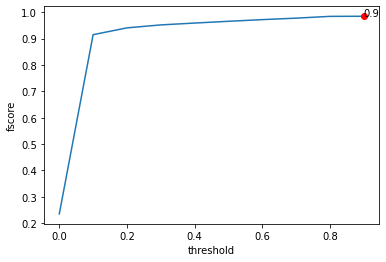

In [40]:
#### Grid Search
logger.info('grid search starts.')
#### set start and end for threshold
print(splited_train.shape, splited_validate.shape)
threshold_start = 0
threshold_end = 1
threshold_step = 0.1
threshold_ary = np.arange(threshold_start,threshold_end,threshold_step)
threshold_ary = np.round(threshold_ary, 3)
val_pred = model.predict(X_val)

#### multi-process find best threshold with grid search
fscore_lst = []
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(FscoreFromGridSearch, i, splited_validate, val_pred) for i in threshold_ary] #FscoreFromGridSearch(i, df, answer_df)
    with tqdm(total=len(threshold_ary),position=0,leave=True) as MulProcessBar:
        for fut in concurrent.futures.as_completed(futures):
            fscore_lst.append(fut.result())
            MulProcessBar.update(1)
            MulProcessBar.refresh()
logger.info('grid search ends.')


#### plot grid search result
logger.info('plot grid search result.')
fscore_df = pd.DataFrame({'threshold':threshold_ary,'fscore':fscore_lst})
print('fscore_df:', fscore_df, sep='\n')
max_loc = fscore_df.fscore.argmax()
sns.lineplot(x='threshold', y='fscore', data=fscore_df)
plt.plot(fscore_df.loc[max_loc].threshold, fscore_df.loc[max_loc].fscore, 'ro')
plt.annotate(fscore_df.loc[max_loc].threshold,
             (fscore_df.loc[max_loc].threshold, fscore_df.loc[max_loc].fscore+0.002))

## Model Result
* save model
* train history with loss and accuracy in each epoch (plot)
* predict test data

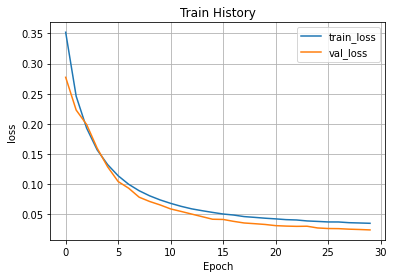

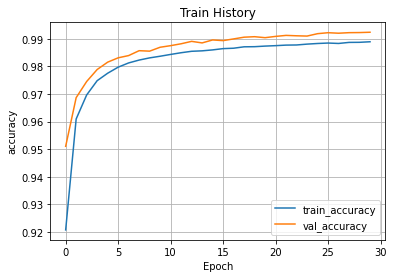

In [45]:
#### save model / load model
model_version = f'model_{"".join(str(datetime.now().date()).split("-"))}'
model.save(f'./predict_result/{model_version}.h5')
# model = load_model('./predict_result/{model_version}.h5')

#### plot train history with loss and accuracy
show_train_history(train_history, target='loss')
show_train_history(train_history, target='accuracy')

In [31]:
#### predict testdata with gridsearch cut point and get f_score
if 'predict' in X_test.columns: X_test = X_test.drop(columns=['predict']) 
test_pred = np.ravel(model.predict(X_test)>fscore_df.loc[max_loc].threshold)
test_df['predict'] = test_pred

fscore = label_evaluation(test_df[['KPI ID','timestamp','label','predict']], delay)
print(fscore)

0.7660237262097807
